## Import libraries and some user-defined functions

In [1]:
import joblib
import mlflow
import numpy as np
import os, gc, sys
import pandas as pd
import seaborn as sns
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import kstest, t
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.outliers_influence import OLSInfluence

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate
from src.utils.boxplots_plotter import boxplots_plotter
from src.loaders.data_loader import load_energy_efficiency_dataset
from src.models.non_linear_models.btree_regressor import optimized_btree_regressor
from src.transformers.data_transformer import transform_energy_efficiency_dataset
from src.models.linear_models.pca_regressor import pca_regressor, optimized_pca_regressor

DETECT_CHANGE_IN_DATA = False # No needed to change it to TRUE

## Import data from  UC Irvine Machine learning Repository

In [2]:
downloaded_features_df, downloaded_targets_df = load_energy_efficiency_dataset()
locally_loaded_features_df, locally_loaded_targets_df = pd.read_csv("../data/features.csv").map(float), pd.read_csv("../data/targets.csv").map(float)

In [3]:
if DETECT_CHANGE_IN_DATA:
    try:
        pd.testing.assert_frame_equal(downloaded_features_df, locally_loaded_features_df, check_exact=False)
        pd.testing.assert_frame_equal(downloaded_targets_df, locally_loaded_targets_df, check_exact=False)
        print("No change detected in data.")
        features_df, targets_df = downloaded_features_df, downloaded_targets_df
    except AssertionError:
        print("Some changes are present in the data.")
        features_df, targets_df = locally_loaded_features_df, locally_loaded_targets_df

    del downloaded_features_df, downloaded_targets_df, locally_loaded_features_df, locally_loaded_targets_df

features_df, targets_df = downloaded_features_df, downloaded_targets_df
del downloaded_features_df, downloaded_targets_df

gc.collect()

45

In [4]:
features_df.shape

(768, 8)

In [5]:
features_df.sample(n=3, random_state=123)

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution
236,0.62,808.5,367.5,220.5,3.5,2.0,0.10,4.0
395,0.86,588.0,294.0,147.0,7.0,5.0,0.25,3.0
36,0.66,759.5,318.5,220.5,3.5,2.0,0.00,0.0


In [6]:
targets_df.sample(n=3, random_state=123)

,Heating_Load,Cooling_Load
236,12.85,14.37
395,29.07,29.82
36,7.18,12.40


## Data preview

The dataset originates from a study that analyzes 768 building shapes to evaluate their heating and cooling load requirements, which are key indicators of energy efficiency. This assessment is based on various building parameters.
Samples of these key indicators were generated through simulations conducted using the Ecotect software.

For further details, you can refer to the following resources:

- **UC Irvine Machine Learning Repository:** [Energy Efficiency Dataset](https://archive.ics.uci.edu/dataset/242/energy+efficiency)
- **Related Research Article:** [Assessing Heating and Cooling Loads](https://doi.org/10.1016/j.enbuild.2012.03.003)


### Features

In [7]:
for col in features_df.columns:
    print(f"Feature: {col}, Number of unique values: {features_df[col].nunique()}")

Feature: Relative_Compactness, Number of unique values: 12
Feature: Surface_Area, Number of unique values: 12
Feature: Wall_Area, Number of unique values: 7
Feature: Roof_Area, Number of unique values: 4
Feature: Overall_Height, Number of unique values: 2
Feature: Orientation, Number of unique values: 4
Feature: Glazing_Area, Number of unique values: 4
Feature: Glazing_Area_Distribution, Number of unique values: 6


In [8]:
for col in features_df.columns:
    print(f"Value counts for column '{col}':")
    print(features_df[col].value_counts())
    print('-' * 40)

Value counts for column 'Relative_Compactness':
Relative_Compactness
0.98    64
0.90    64
0.86    64
0.82    64
0.79    64
0.76    64
0.74    64
0.71    64
0.69    64
0.66    64
0.64    64
0.62    64
Name: count, dtype: int64
----------------------------------------
Value counts for column 'Surface_Area':
Surface_Area
514.5    64
563.5    64
588.0    64
612.5    64
637.0    64
661.5    64
686.0    64
710.5    64
735.0    64
759.5    64
784.0    64
808.5    64
Name: count, dtype: int64
----------------------------------------
Value counts for column 'Wall_Area':
Wall_Area
294.0    192
318.5    192
343.0    128
416.5     64
245.0     64
269.5     64
367.5     64
Name: count, dtype: int64
----------------------------------------
Value counts for column 'Roof_Area':
Roof_Area
220.50    384
147.00    192
122.50    128
110.25     64
Name: count, dtype: int64
----------------------------------------
Value counts for column 'Overall_Height':
Overall_Height
7.0    384
3.5    384
Name: count, d

Although each feature is designed to capture a continuous attribute of residential properties, empirical distributions in available samples display few diverse values compared to what would be expected from the general population. Current samples do not fully represent the diversity present in the broader context, but rather reflect only a subset of it.

In [9]:
features_df.describe()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000


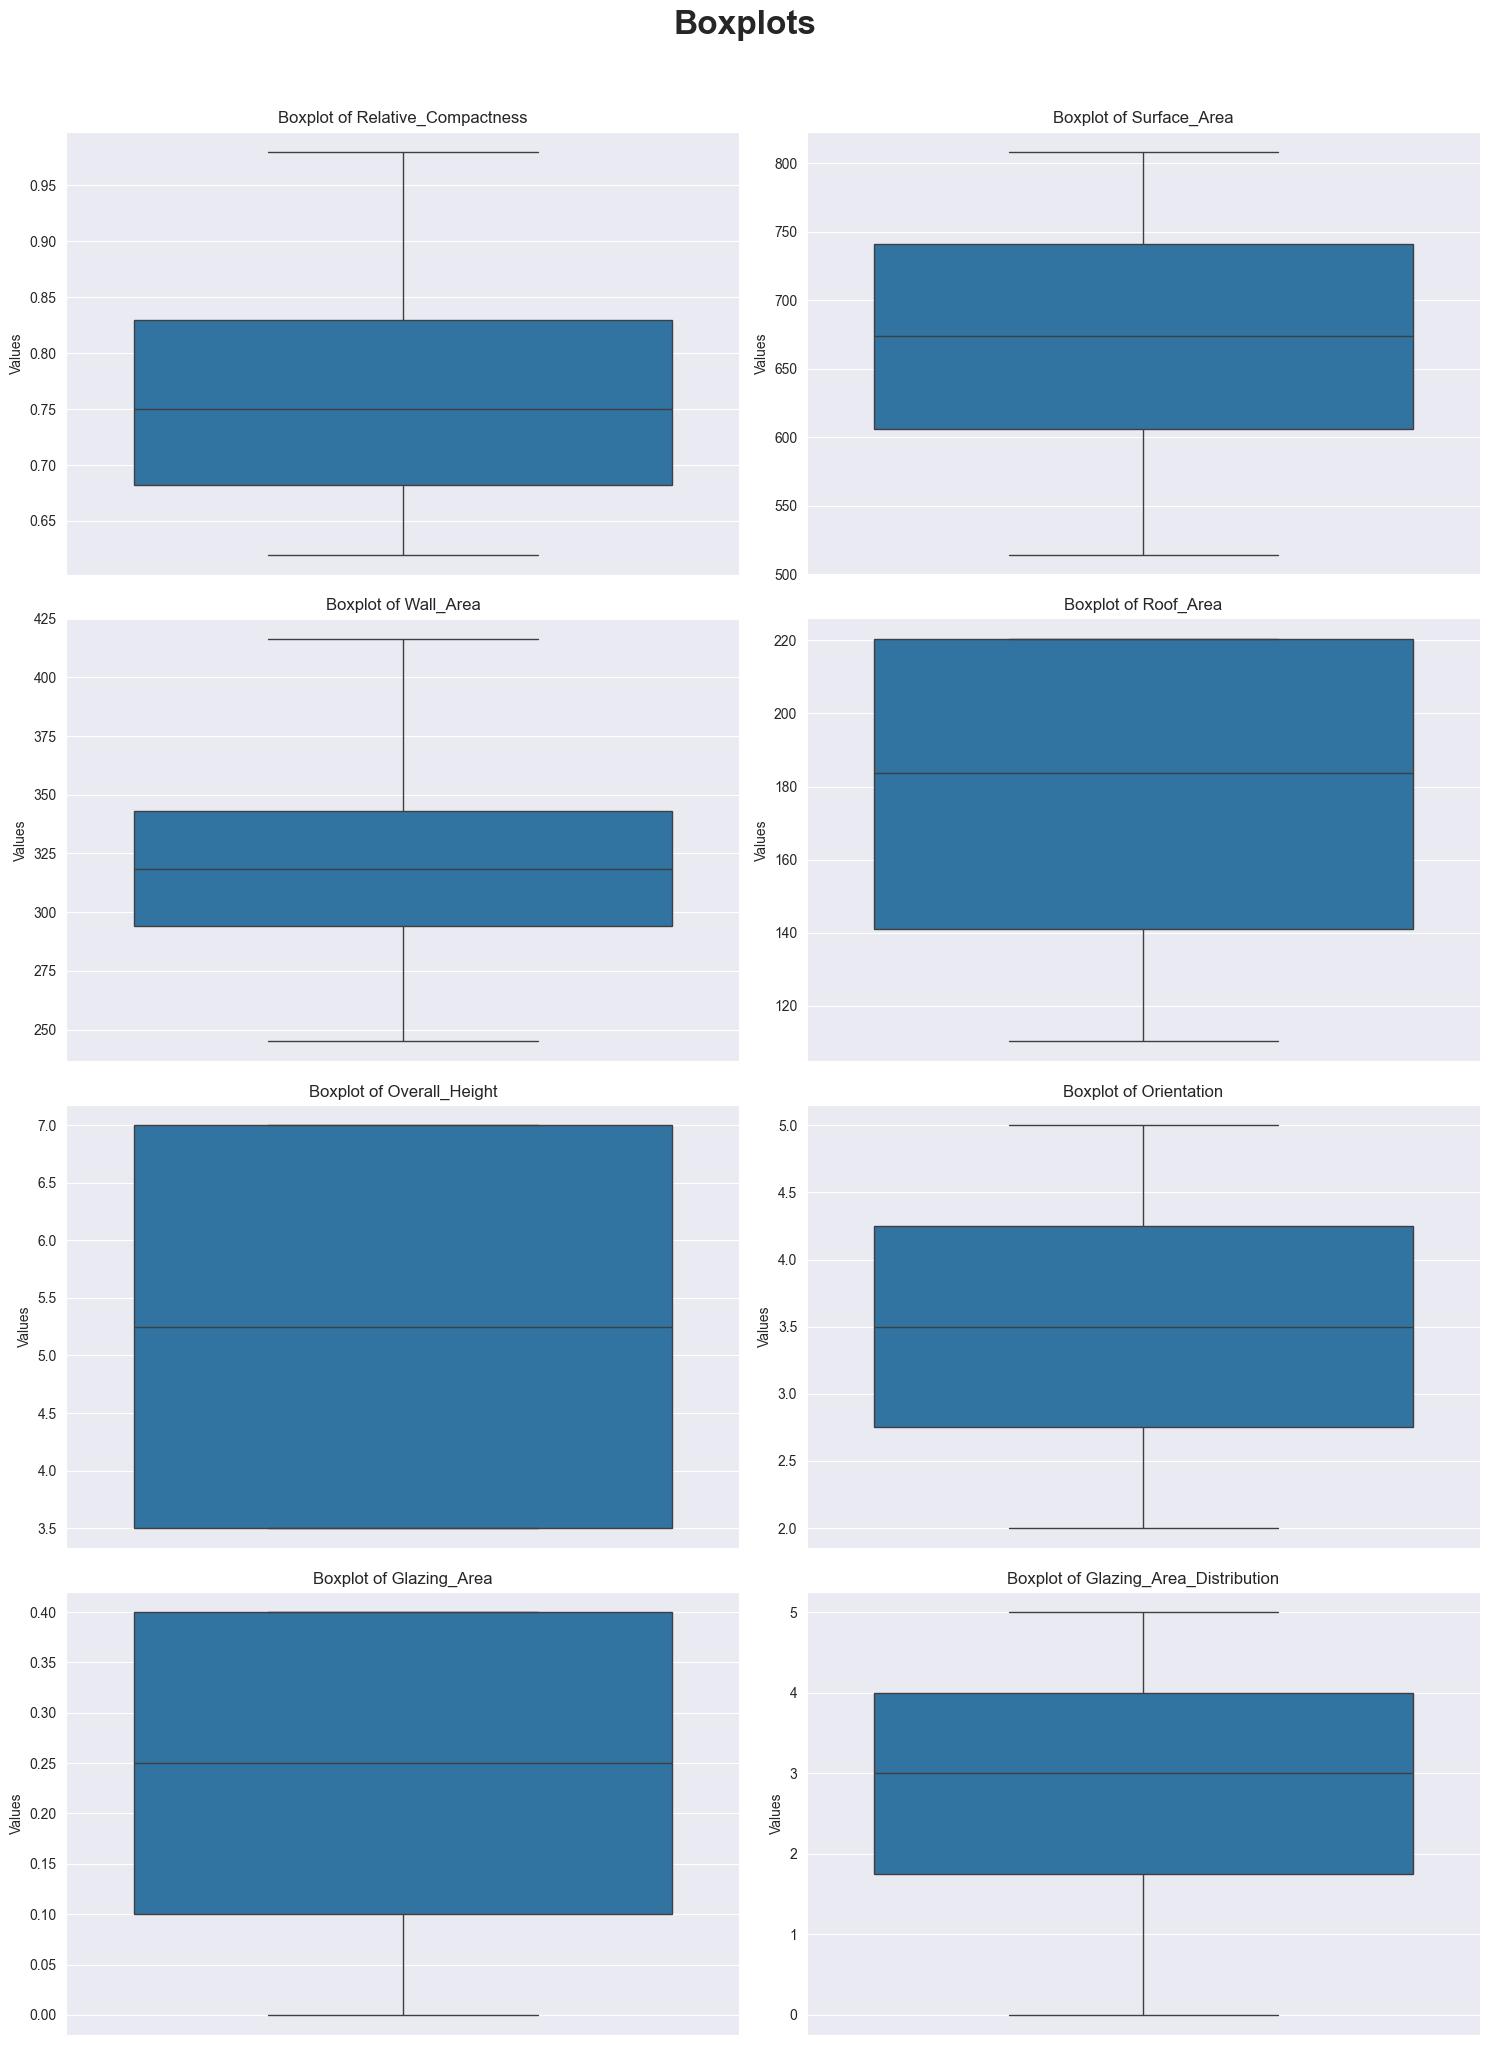

In [10]:
boxplots_plotter(df=features_df)

Features have means quite close to medians and, no extremely low/high values are present in their distributions.

### Targets

In [11]:
for col in targets_df.columns:
    print(f"Target: {col}, Number of unique values: {targets_df[col].nunique()}")

Target: Heating_Load, Number of unique values: 586
Target: Cooling_Load, Number of unique values: 636


In [12]:
targets_df.describe()

,Heating_Load,Cooling_Load
count,768.000000,768.000000
mean,22.307201,24.587760
std,10.090196,9.513306
min,6.010000,10.900000
25%,12.992500,15.620000
50%,18.950000,22.080000
75%,31.667500,33.132500
max,43.100000,48.030000


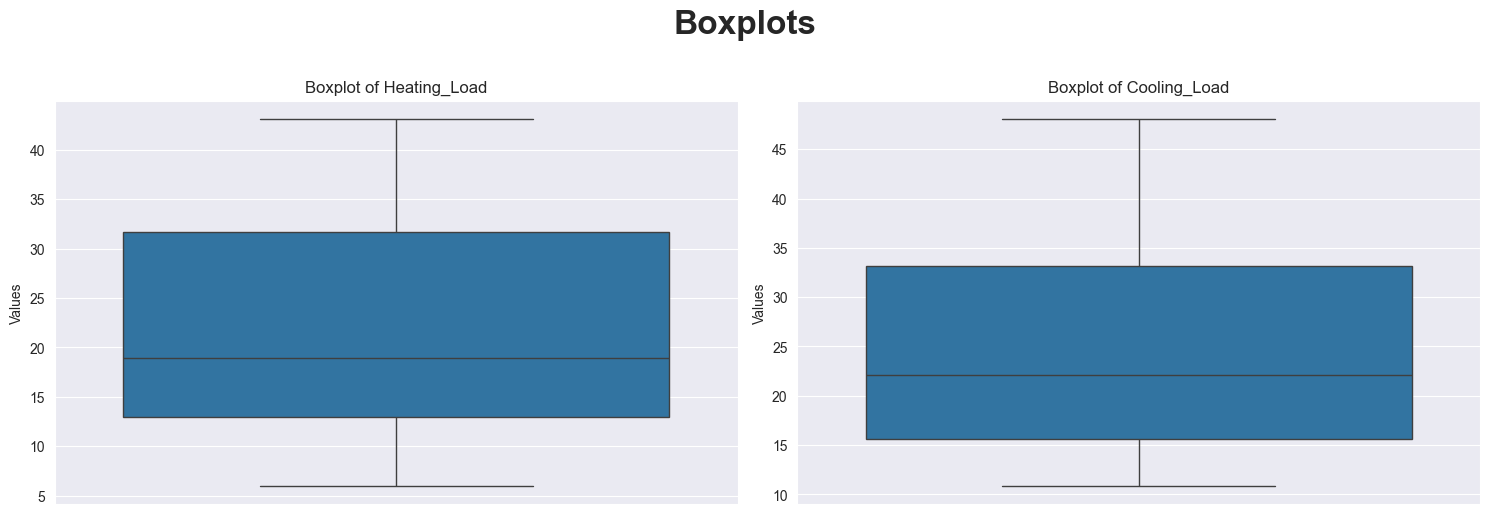

In [13]:
boxplots_plotter(df=targets_df)

Samples values of targets are as diverse as they should be for continuous measures, and no extremely high or low value is present in their distributions.

## Data Splitting

In [14]:
data = transform_energy_efficiency_dataset(features_df=features_df, targets_df=targets_df)

del features_df, targets_df
gc.collect()

5821

In the splitting, we have two versions of the data: train (standardized/ non standardized), test (standardized/ non standardized).
No special feature engineering will be done at this step, and we will proceed to models training.

## Models Training

### Linear models

Before running any kind of linear models, we'll compute some linear correlations between features and targets.

In [15]:
train_features_df = data["train"]["features"]["original"]
train_targets_df = data["train"]["targets"]

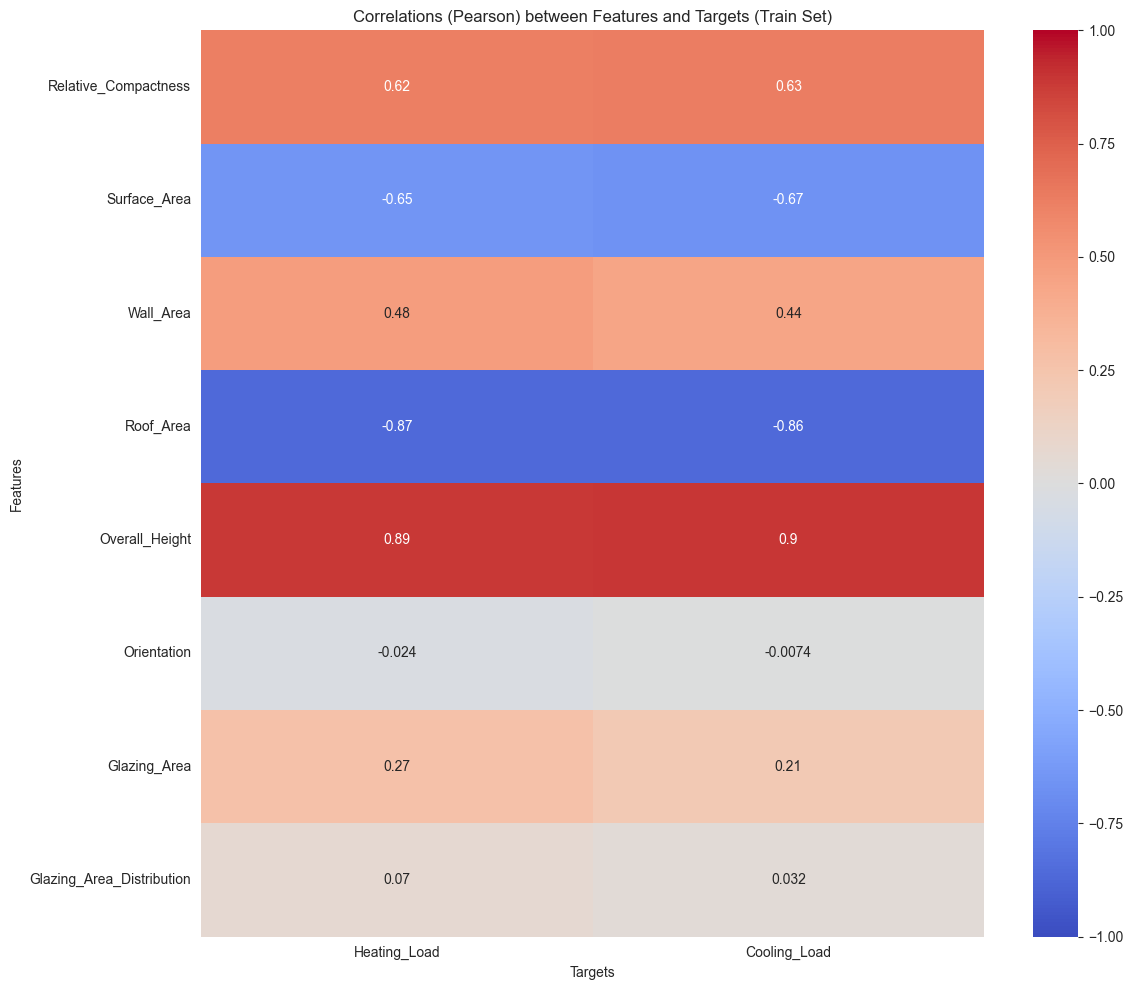

In [16]:
# Compute correlation between each feature and each target
correlation_matrix = train_features_df.corrwith(train_targets_df, axis=0, method='pearson')

# If you want a full matrix (features x targets):
correlation_matrix = pd.DataFrame({
    target: train_features_df.corrwith(train_targets_df[target], method='pearson')
    for target in train_targets_df.columns
})

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0)
plt.title("Correlations (Pearson) between Features and Targets (Train Set)")
plt.xlabel("Targets")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

Linear correlations between the features and the targets generally range from -86% to 90%. This indicates a strong linear relationship in several cases, which justifies the use of linear modeling techniques (e.g. linear regression) to predict the targets from the features.

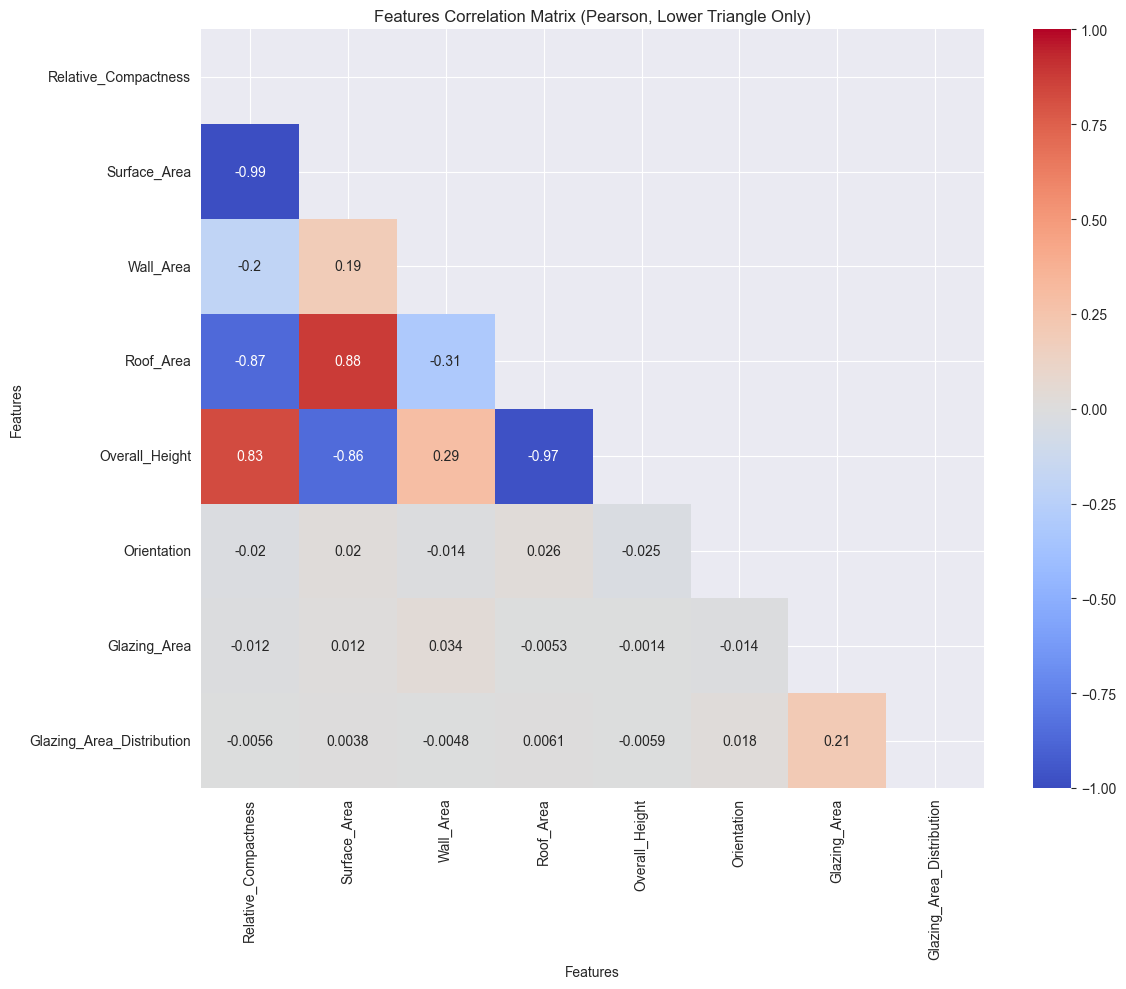

In [17]:
# Compute the correlation matrix for features
corr_matrix = train_features_df.corr(method='pearson')

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot the heatmap with the mask applied
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    center=0
)
plt.title("Features Correlation Matrix (Pearson, Lower Triangle Only)")
plt.xlabel("Features")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

Strong linear correlations are present between some features: for example, Overall_Height and Roof_Area are correlated up to -97%. Introducing features as they're in a traditional linear regression model will be problematic.
Instead of a traditional linear regression model, we'll be using a PCA regression.

In [18]:
del corr_matrix, train_features_df, train_targets_df
gc.collect()

33684

In [19]:
training_pca_reg_results = pca_regressor(
    features_df=data["train"]["features"]["scaled"],
    targets_df=data["train"]["targets"],
    operation_mode="train",
)

Firstly, we need to verify if models' coefficients are significant and, if overall performances are good (are models able to learn ?).

In [20]:
print(training_pca_reg_results["Heating_Load"]["model"].model.summary())

                            OLS Regression Results                            
Dep. Variable:           Heating_Load   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     956.2
Date:                Sun, 06 Jul 2025   Prob (F-statistic):          2.82e-285
Time:                        00:04:00   Log-Likelihood:                -1621.5
No. Observations:                 614   AIC:                             3255.
Df Residuals:                     608   BIC:                             3282.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.4100      0.138    162.811      0.0

In [21]:
print(training_pca_reg_results["Cooling_Load"]["model"].model.summary())

                            OLS Regression Results                            
Dep. Variable:           Cooling_Load   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     664.1
Date:                Sun, 06 Jul 2025   Prob (F-statistic):          1.45e-243
Time:                        00:04:00   Log-Likelihood:                -1685.5
No. Observations:                 614   AIC:                             3383.
Df Residuals:                     608   BIC:                             3410.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.6896      0.153    161.620      0.0

As displayed by models' summaries :
- Both models are able to learn since the proportion of targets' variance explained is at least 84%.
- Some of their coefficients aren't significant with respect to a 5% risk level. For example, for Cooling_load the PC3 could be removed, and for Heating_Load, both PC3, PC4 could be discarded.

We need to apply variable selection techniques to retain only significant ones in final models. Since we had only up to 5 PCs introduced in models, we decide to use an exhaustive search base on BIC criteria for this selection.

In [22]:
del training_pca_reg_results
gc.collect()

0

In [23]:
training_pca_reg_results = optimized_pca_regressor(
    features_df=data["train"]["features"]["scaled"],
    targets_df=data["train"]["targets"],
    operation_mode="train",
)

In [24]:
print(training_pca_reg_results["Heating_Load"]["model"].model.summary())

                            OLS Regression Results                            
Dep. Variable:           Heating_Load   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     1585.
Date:                Sun, 06 Jul 2025   Prob (F-statistic):          1.82e-287
Time:                        00:04:00   Log-Likelihood:                -1623.9
No. Observations:                 614   AIC:                             3256.
Df Residuals:                     610   BIC:                             3273.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.4100      0.138    162.455      0.0

In [25]:
print(training_pca_reg_results["Cooling_Load"]["model"].model.summary())

                            OLS Regression Results                            
Dep. Variable:           Cooling_Load   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     1100.
Date:                Sun, 06 Jul 2025   Prob (F-statistic):          1.61e-245
Time:                        00:04:00   Log-Likelihood:                -1688.1
No. Observations:                 614   AIC:                             3384.
Df Residuals:                     610   BIC:                             3402.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.6896      0.153    161.220      0.0

In [26]:
test_pca_reg_results = pca_regressor(
    features_df=data["test"]["features"]["scaled"],
    targets_df=data["test"]["targets"],
    operation_mode="test",
    train_results=training_pca_reg_results,
)

pca_reg_perfs = []

for target_name in data["train"]["targets"].columns:
    pca_reg_perfs.append(
            {
                "Target": target_name,

                "Train MSE": f"{training_pca_reg_results[target_name]['train_mse_score']:.3f}",
                "Train MAPE(%)": f"{training_pca_reg_results[target_name]['train_mape_score']:.3f}",

                "Validation MSE": f"{training_pca_reg_results[target_name]['val_mse_score']:.3f}",
                "Validation MAPE(%)": f"{training_pca_reg_results[target_name]['val_mape_score']:.3f}",

                "Test MSE": f"{test_pca_reg_results[target_name]['mse_score']:.3f}",
                "Test MAPE(%)": f"{test_pca_reg_results[target_name]['mape_score']:.3f}",
            }
        )

pca_reg_perfs_df = pd.DataFrame(pca_reg_perfs)
pca_reg_perfs_df


,Target,Train MSE,Train MAPE(%),Validation MSE,Validation MAPE(%),Test MSE,Test MAPE(%)
0,Heating_Load,11.592,11.609,11.749,11.694,14.105,12.632
1,Cooling_Load,14.290,10.760,14.448,10.832,14.157,10.734


- Optimized models based on BIC criteria have all their coefficients significant with a 5% risk level.
- **Training** and **validation** metrics are showing that no overfitting case is present in the models.
- **On test samples**, models are expected to do a MAPE (Mean Absolute Percentage Error) error ranging from 10% to 12%, and are able to explain from 84% up to 88% of targets' variability.

Although these results seem good, we need to verify assumptions of linear models:
- Errors must be uncorrelated.
- Errors must be gaussian white noise.

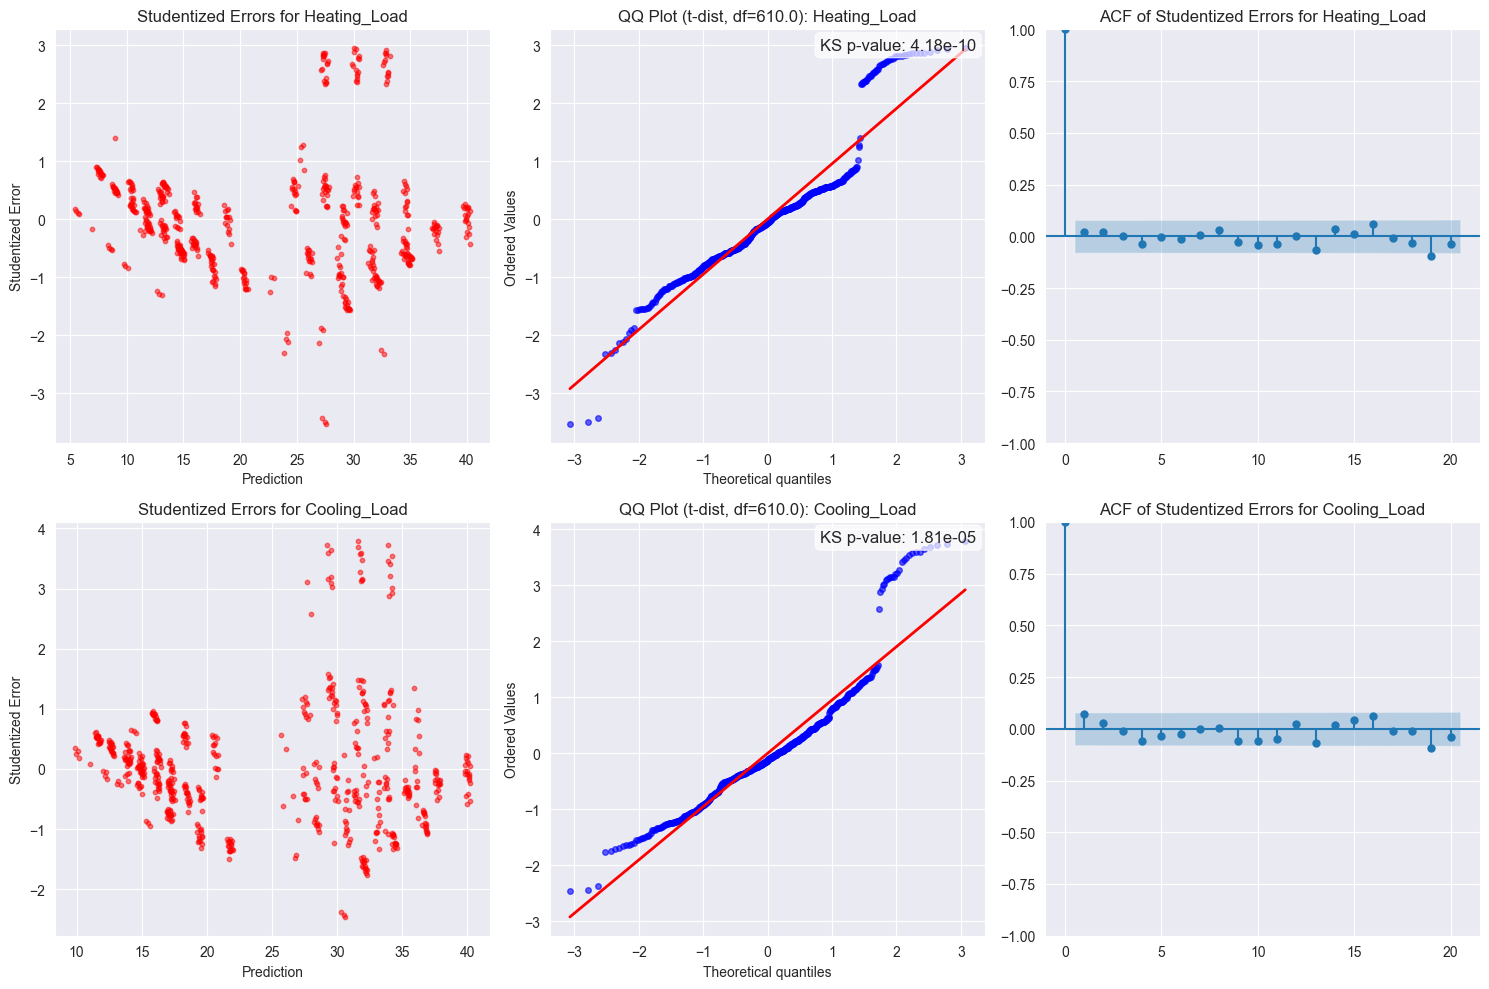

In [27]:
n_targets = len(data["train"]["targets"].columns)
n_rows = n_targets
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), squeeze=False)
fig.tight_layout(pad=3.0)

for x, target in enumerate(data["train"]["targets"].columns):

    ax_error = axes[x, 0]
    ax_qq = axes[x, 1]
    ax_acf = axes[x, 2]
    actual_df = data["train"]["targets"][target].reset_index(drop=True).squeeze()
    predicted_df = training_pca_reg_results[target]["predictions"].reset_index(drop=True).squeeze()

    # Get fitted OLS model for this target
    ols_model = training_pca_reg_results[target]["model"].model  # .model is the statsmodels OLSResults object
    studentized_error_df = pd.Series(OLSInfluence(ols_model).resid_studentized, name='Studentized_residuals')

    # Kolmogorov-Smirnov test against t-distribution
    freedom_degree = actual_df.shape[0] - 1 - ols_model.df_model   # Degrees of freedom
    ks_stat, ks_pvalue = kstest(studentized_error_df, t.cdf, args=(freedom_degree,))
    stats_text = f"KS p-value: {ks_pvalue:.3g}"

    # Scatter plot
    ax_error.scatter(predicted_df.values, studentized_error_df.values, color="red", s=10, alpha=0.5)
    ax_error.set_title(f"Studentized Errors for {target}")
    ax_error.set_xlabel("Prediction")
    ax_error.set_ylabel("Studentized Error")

    # QQ plot
    (osm, osr), _ = stats.probplot(studentized_error_df, dist='t', sparams=(freedom_degree,), plot=ax_qq)
    ax_qq.get_lines()[0].set_markersize(4.0)
    ax_qq.get_lines()[0].set_markerfacecolor('blue')
    ax_qq.get_lines()[0].set_alpha(0.6)
    ax_qq.get_lines()[1].set_linewidth(2.0)
    ax_qq.set_title(f"QQ Plot (t-dist, df={freedom_degree:.1f}): {target}")
    ax_qq.text(
        0.98, 0.98, stats_text,
        transform=ax_qq.transAxes,
        fontsize=12,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
    )

    # ACF plot
    plot_acf(studentized_error_df, ax=ax_acf, lags=20, alpha=0.05)
    ax_acf.set_title(f"ACF of Studentized Errors for {target}")

plt.tight_layout()
plt.show()

ACF plot shows that Studentized residuals are uncorrelated. Based on QQ plot, we need more information to consider that they follow a Student distribution with a 5% risk level. Plots of studentized residuals against predicted values do not confirm homoscedasticity.
Only models' outputs such as coefficients' estimates, residual standard errors and adjusted r-squared could be used.

We consider this model as a base one, and will investigate non-linear models such as decision trees.

In [28]:
del pca_reg_perfs
gc.collect()

30

### Launch MLflow server to record training experiments

We will run some MLflow experiments locally (necessary at the non-linear models training). Make sure to run in your terminal this command :

`mlflow server --host localhost --port 9999`.

You can change the server uri and port according to your setup.

In [29]:
mlflow.set_tracking_uri("http://localhost:9999")

### Non Linear models (Decision Trees)

We make a quick computation of a decision tree model to have an overview of its capacity on the dataset.

In [30]:
dt_reg = DecisionTreeRegressor(random_state=123)

cv_results = cross_validate(
    dt_reg,
    data["train"]["features"]["original"],
    data["train"]["targets"],
    cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=True,
)
train_mses = -cv_results['train_score']
val_mses = -cv_results['test_score']

print("Train MSE per fold:", train_mses)
print("Validation MSE per fold:", val_mses)
print(f"Mean Train MSE: {train_mses.mean():.3f}")
print(f"Mean Validation MSE: {val_mses.mean():.3f}")

Train MSE per fold: [9.63984813e-33 9.63984813e-33 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
Validation MSE per fold: [2.25912073 2.40774431 2.63470366 3.95352033 4.04944754]
Mean Train MSE: 0.000
Mean Validation MSE: 3.061


In [31]:
del dt_reg, cv_results, val_mses, train_mses

Results are showing that a decision tree is able to learn patterns on the dataset, but at the same time we need to be careful to not overfit as shown by the comparison of validation and training results. We resort to boosting to fight the noticed overfitting.

In [32]:
training_btree_reg_results = optimized_btree_regressor(
    features_df=data["train"]["features"]["original"],
    targets_df=data["train"]["targets"],
    operation_mode="train",
    experiment_name=f"/gb_tree_training_{datetime.now().strftime('%Y-%m-%d')}"
)

Experiment /gb_tree_training_2025-07-06 exists and is active.
🏃 View run indecisive-swan-806 at: http://localhost:9999/#/experiments/684550179626348620/runs/da31dd7c7f434f4dae2dfc4177c2f59b

🧪 View experiment at: http://localhost:9999/#/experiments/684550179626348620

🏃 View run valuable-moth-845 at: http://localhost:9999/#/experiments/684550179626348620/runs/f4295a4c7950412082ebdb2b196c102d

🧪 View experiment at: http://localhost:9999/#/experiments/684550179626348620   

🏃 View run puzzled-ox-415 at: http://localhost:9999/#/experiments/684550179626348620/runs/b72d221aea8943dfaf6c693fd60a442e

🧪 View experiment at: http://localhost:9999/#/experiments/684550179626348620  

🏃 View run treasured-ram-292 at: http://localhost:9999/#/experiments/684550179626348620/runs/2543879e74004077bc3db02b4b2a9d96

🧪 View experiment at: http://localhost:9999/#/experiments/684550179626348620   

🏃 View run adaptable-cub-601 at: http://localhost:9999/#/experiments/684550179626348620/runs/4b89686275bc4af8a9

In [33]:
test_btree_reg_results = optimized_btree_regressor(
    features_df=data["test"]["features"]["original"],
    targets_df=data["test"]["targets"],
    operation_mode="test",
    best_run=training_btree_reg_results
)

In [34]:
btree_reg_perfs_df = pd.DataFrame(
    {
        "Train MAPE (%)": [f"{training_btree_reg_results['train_mape_score']:.3f}"],
        "Train MSE": [f"{training_btree_reg_results['train_mse_score']:.3f}"],
        "Train R2": [f"{training_btree_reg_results['train_r2_score']:.3f}"],

        "Validation MAPE (%)": [f"{training_btree_reg_results['val_mape_score']:.3f}"],
        "Validation MSE": [f"{training_btree_reg_results['val_mse_score']:.3f}"],
        "Validation R2": [f"{training_btree_reg_results['val_r2_score']:.3f}"],

        "Test MAPE (%)": [f"{test_btree_reg_results['mape_score']:.3f}"],
        "Test MSE": [f"{test_btree_reg_results['mse_score']:.3f}"],
        "Test R2": [f"{test_btree_reg_results['r2_score']:.3f}"],
    }
)

btree_reg_perfs_df

,Train MAPE (%),Train MSE,Train R2,Validation MAPE (%),Validation MSE,Validation R2,Test MAPE (%),Test MSE,Test R2
0,0.025,1.126,0.988,0.027,1.351,0.985,2.772,1.589,0.982


- The boosted tree model demonstrates strong generalization ability: on average, we can expect a MAPE of 2.77% on new data predictions, with an average explained variance (R²) of 98.2%.
- The boosted tree significantly outperforms linear regression, achieving notably lower prediction errors and higher explained variability.

In [35]:
training_btree_reg_results["features_importance"]

,feature,importance
0,Relative_Compactness,0.368463
1,Surface_Area,0.112650
2,Wall_Area,0.046598
3,Roof_Area,0.196693
4,Overall_Height,0.194281
5,Orientation,0.004335
6,Glazing_Area,0.055709
7,Glazing_Area_Distribution,0.021271


- Feature Importance:
  In our boosted tree configuration, Relative_compactness emerges as the most important feature for predicting the target values. This finding is coherent, as the compactness or isolation of a house directly influences its energy efficiency—more compact or better-insulated houses would typically require less electricity for heating or cooling.

- Model Selection:
    Given its strong performance, the boosted tree model will be retained as the final model for the energy efficiency prediction task.

In [36]:
final_predictor = training_btree_reg_results["model"]
joblib.dump(final_predictor, "final_predictor.joblib") # Save the model locally
actual_values_df = data["test"]["targets"]
predicted_values_df = pd.DataFrame(
    data=final_predictor.predict(data["test"]["features"]["original"]),
    columns=data["test"]["targets"].columns,
)

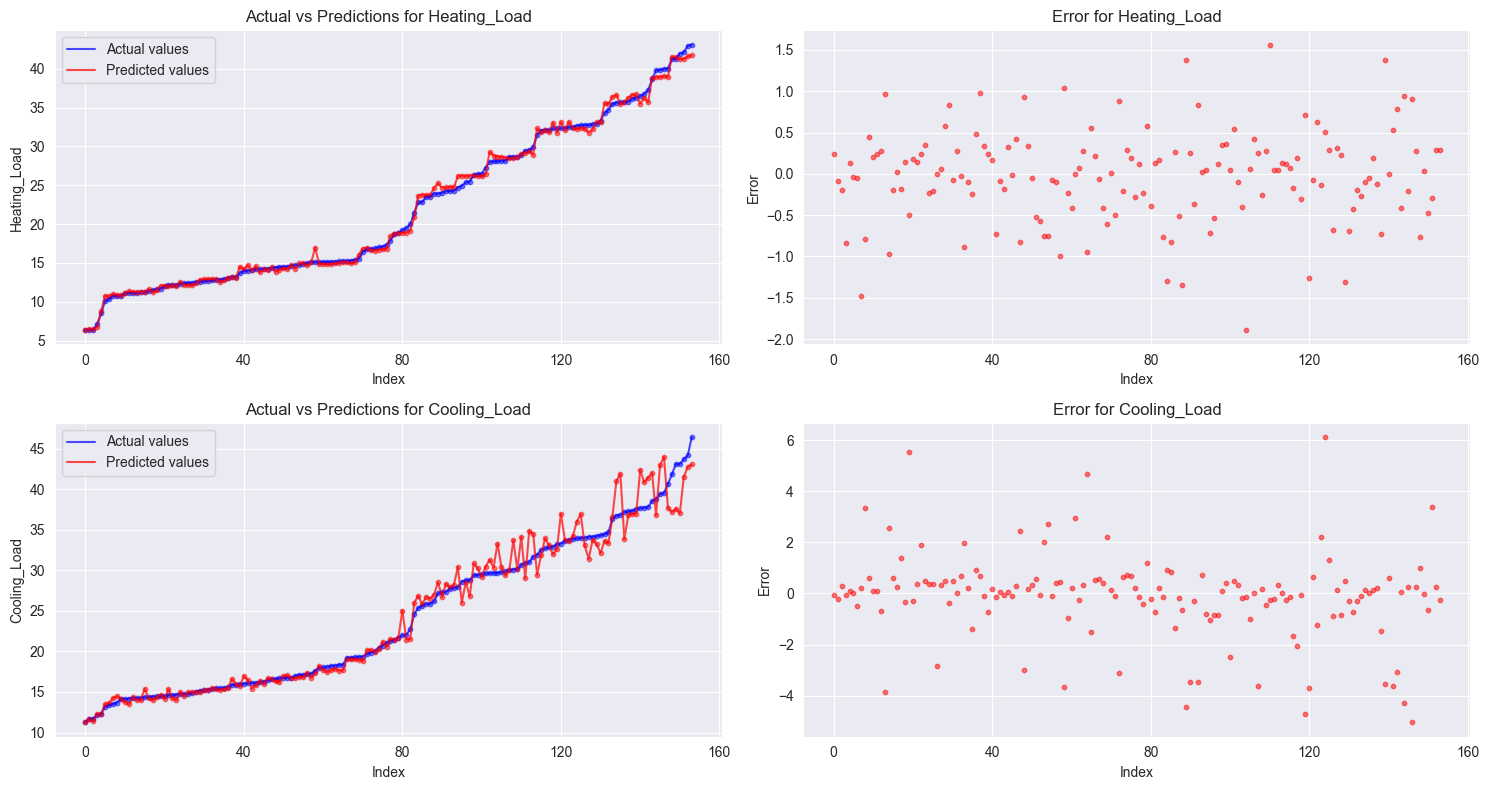

In [37]:
n_targets = len(actual_values_df.columns)
n_rows = n_targets
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows), squeeze=False)

for idx, target in enumerate(actual_values_df.columns):
    # --- Actual vs Predicted ---
    ax = axes[idx, 0]
    combined_df = pd.DataFrame({
        'actual': actual_values_df[target].reset_index(drop=True),
        'predicted': predicted_values_df[target].reset_index(drop=True),
    })
    sorted_combined_df = combined_df.sort_values(by='actual').reset_index(drop=True)

    ax.plot(sorted_combined_df.index, sorted_combined_df['actual'], "b-", label="Actual values", alpha=0.7)
    ax.scatter(sorted_combined_df.index, sorted_combined_df['actual'], color="blue", s=10, alpha=0.5)
    ax.plot(sorted_combined_df.index, sorted_combined_df['predicted'], "r-", label="Predicted values", alpha=0.7)
    ax.scatter(sorted_combined_df.index, sorted_combined_df['predicted'], color="red", s=10, alpha=0.5)
    ax.set_title(f"Actual vs Predictions for {target}")
    ax.set_xlabel("Index")
    ax.set_ylabel(target)
    ax.legend()
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))

    # --- Error scatter ---
    ax_error = axes[idx, 1]
    actual_df = actual_values_df[target].reset_index(drop=True)
    predicted_df = predicted_values_df[target].reset_index(drop=True)
    error_df = actual_df - predicted_df
    ax_error.scatter(predicted_df.index, error_df.values, color="red", s=10, alpha=0.5)
    ax_error.set_title(f"Error for {target}")
    ax_error.set_xlabel("Index")
    ax_error.set_ylabel("Error")
    ax_error.xaxis.set_major_locator(plt.MaxNLocator(5))

plt.tight_layout()
plt.show()

In [38]:
gc.collect()

15